<a href="https://colab.research.google.com/github/wxbaum/twitter_user_scraper/blob/master/twitter_user_scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Scraper for Twitter User Data 

Utilizing the googlesearch module with Tweepy.

In [0]:
import tweepy
import time
import pandas as pd
import numpy as np
import json
import time
from random import randint, random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
"""
These keys/tokens require a Twitter developer account. Sign up for a developer 
account at https://developer.twitter.com and create a new app.
""" 

api_key = 'aoGosXnGsr6KM1VHpISICxRPI'
secret_key = 'fEyygkhWQK6aaIHqONLdPhhRs4hvqrgyZu3OuWE6PCo2bUXQus'
access_token = '141198705-IlSTJwpgWm5PrOPbpO35pRJv5OxIAAu8b67Alo9j'
secret_token = 'd4yu7qhV80Wn2gXKDHuLJ3mb1osEYH88ck91mIWbkBC9a'

def authenticate(api_key, secret_key, access_token, secret_token):

    auth = tweepy.OAuthHandler(api_key, secret_key)
    auth.set_access_token(access_token, secret_token)
    api = tweepy.API(auth, 
                     wait_on_rate_limit=True, 
                     wait_on_rate_limit_notify=True)
  
    return api


api = authenticate(api_key, secret_key, access_token, secret_token)

In [0]:
# Some api calls will result in a rate limit. This functions handles those if needed 
def limit_handled(cursor):
    
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            time.sleep(2)
            continue

In [0]:
def scrape_influencers_use_google(list_contains_string):
    
    from googlesearch import search
    from random import randint

    list_urls = []

    urls_checked = 0
    urls_appended = 0
    for url in search("site:twitter.com " + list_contains_string, 
                      start=urls_checked, 
                      num=10, 
                      pause=randint(3, 5)):
        
        if '/lists/' in url:
            list_urls.append(url)
            urls_appended += 1
            urls_checked += 1

        if urls_checked / urls_appended > 5:
            break
            
        elif urls_appended >= 50:
            break

        time.sleep(randint(3, 5))

    list_urls = [url[8:] for url in list_urls] # Removes leading https://

    return list_urls
  

list_urls = scrape_influencers_use_google("lists influencers")

In [0]:
# Get user id, screen name, bio, follower count

def get_users_in_lists(influencer_lists):
  
    users_list = []
    bios_list = []
    desc_list = []
    follower_count_list = []
    
    for tw_list in influencer_lists:
    
        user = tw_list.split('/')[1]
        list_name = tw_list.split('/')[3]

        list_members_output = api.list_members(user, list_name)

        for user_id in list_members_output:
            users_list.append(user_id._json['id'])
            bios_list.append(user_id._json['screen_name'])
            desc_list.append(user_id._json['description'])
            follower_count_list.append(user_id._json['followers_count'])
            
    zipped_data = zip(users_list, bios_list, desc_list, follower_count_list)
    output_df = pd.DataFrame(list(zipped_data), columns=['user_id', 
                                                         'screen_name',
                                                         'bio',
                                                         'followers'])
    output_df.set_index('user_id', inplace=True)
    
    return output_df
  

influencers_df = get_users_in_lists(list_urls)

In [6]:
influencers_df.head()

,screen_name,bio,followers
user_id,,,
411194625,RBraceySherman,Black Feminist • 👩🏽‍💻 @AbortionFunds @Abortion...,16674
272191896,SarahEMcBride,"Author of Tomorrow Will Be Different, Nat'l Pr...",46905
271725689,iamsambee,Alleged humorist.,515023
267915933,feministabulous,host of vox media’s consider it | pre-order my...,136585
260959284,KathaPollitt,"Politics, poetry, feminism, books, life. New ...",20119


Accounts which are protected will not be accessible for the majority of Tweepy user object functionality. These need to be removed. 

When the API connection was built at the start of the script, the wait_on_rate_limit and wait_on_rate_limit_notify parameters were set to true. While those will catch a wait limit error, notify us, and go again when ready, this function checks a lot of users very quickly and will hit the rate limit most of the time if left alone. A sleep timer for each user has been set as a random float up to 0.2 (representing sleep up to 0.2s). This will not prevent rate limit errors 100% of the time but strikes a balance between error prevention and run time. 

Run time for this function is as such maximized at 0.2 * n_users seconds.


In [7]:
def remove_protected_accounts(users_df):
    
    working_df = users_df.copy()
    protected_ids = []
    
    counter = 0
    for index, row in users_df.iterrows():
        user = api.get_user(id=index)._json
        if user['protected'] == True:
            protected_ids.append(index)
        counter += 1
        if counter % 100 == 0:
            print(str(counter) + '/' + str(len(working_df)) + ' IDs checked')
            print('Protected IDs found:', len(protected_ids), '\n')
        # Sleeping for up to 0.2s helps not to exceed Tweepy's rate limit.
        time.sleep(random() / 5)
    
    print('Orignal number of users:', len(working_df))
    working_df.drop(labels=protected_ids, inplace=True)
    print('Modified number of users:', len(working_df))
    
    working_df.reset_index(inplace=True)
            
    return working_df
            

influencers_df = remove_protected_accounts(influencers_df)

100/856 IDs checked
Protected IDs found: 1 

200/856 IDs checked
Protected IDs found: 1 

300/856 IDs checked
Protected IDs found: 4 

400/856 IDs checked
Protected IDs found: 5 

500/856 IDs checked
Protected IDs found: 7 

600/856 IDs checked
Protected IDs found: 7 

700/856 IDs checked
Protected IDs found: 7 

800/856 IDs checked
Protected IDs found: 7 

Orignal number of users: 856
Modified number of users: 849


Now protected accounts have been removed, engagements with users' tweets can be examined. We can't access actual impressions for tweets, but we can access some engagement actions with tweets. By looking at engagement actions in relation to the number of followers a user has, we can see how much their audience is engaged with their content. 

As we've been looking at influencers for the purposes of this script, we can get a fairly good measurement of how effective an influencer might be by looking at metrics like this. 

Certain things require a closer look. For example, there are some celebrities in the influencer lists. It's a fair hypothesis that celebrities have an inhenrently more engaged audience, so insights like that can be considered. For a more business level insight, we could see if there is a follower count sweet spot, or if money spent on influencers vs user engagement has a linear, exponential, or logarithmic signature. 

In [8]:
def calc_median_favorites(user_id):
    
    fav_list = []
    tweets = api.user_timeline(id=user_id, count=100)
    
    for tweet in tweets:
        if tweet._json['text'].startswith('RT'):
            continue
        else:
            fav_list.append(tweet._json['favorite_count'])
    
    time.sleep(random() / 5)
    
    return np.median(fav_list)  


influencers_df['median_favs'] = influencers_df['user_id'].apply(lambda x: calc_median_favorites(x))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [9]:
def calc_median_retweets(user_id):
    
    rt_list = []
    tweets = api.user_timeline(id=user_id, count=100)
    
    for tweet in tweets:
        if tweet._json['text'].startswith('RT'):
            continue
        else:
            rt_list.append(tweet._json['retweet_count'])
    
    time.sleep(random() / 5)
    
    return np.median(rt_list)  


influencers_df['median_rts'] = influencers_df['user_id'].apply(lambda x: calc_median_retweets(x))

Rate limit reached. Sleeping for: 459
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [10]:
influencers_df.head()

,user_id,screen_name,bio,followers,median_favs,median_rts
0,411194625,RBraceySherman,Black Feminist • 👩🏽‍💻 @AbortionFunds @Abortion...,16674,5.0,1.0
1,272191896,SarahEMcBride,"Author of Tomorrow Will Be Different, Nat'l Pr...",46905,9.0,0.0
2,271725689,iamsambee,Alleged humorist.,515023,411.0,44.0
3,267915933,feministabulous,host of vox media’s consider it | pre-order my...,136585,16.0,0.0
4,260959284,KathaPollitt,"Politics, poetry, feminism, books, life. New ...",20119,2.0,0.0


In the median fav/rt calculations, accounts that have never tweeted will have been recorded as nan values. We can check to see if any exist using a heatmap for null values. 

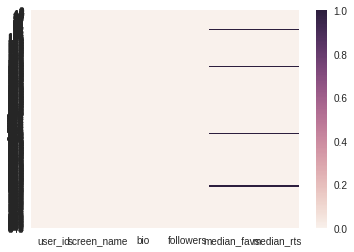

In [13]:
sns.heatmap(influencers_df.isnull())

Since there are nulls, we'll remove those and be left with a clean dataset. Creating a heatmap again confirms this. 

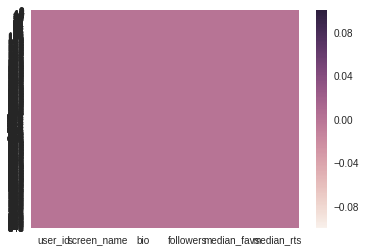

In [17]:
influencers_df = influencers_df.loc[~influencers_df['median_favs'].isnull()]
sns.heatmap(influencers_df.isnull())

Now, to create some kind of engagement metric. 

Firstly, we should remove accounts that are not often interacted with, that is, where media favs == 0. Also since the way we're crowdsourcing this data is highly subjective, we should set a low cutoff for follower count. We'll make this 500. 

Secondle, we need a solid proxy for engagement. We can use the average of median_favs / # of followers and median_rts / # of followers, so we'll create that column now. The resulting array features some small numbers which are difficult to compare. We'll also standardize the column. 

In [0]:
def remove_low_engagement_accounts(df):
    
    working_df = df.copy()
    
    working_df = working_df.loc[(working_df['median_favs'] > 0) &
                                (working_df['followers'] >= 500)]
    
    return working_df

influencers_df = remove_low_engagement_accounts(influencers_df)

In [0]:
def create_engagement_metric(df):
      
    working_df = df.copy()
    
    from sklearn.preprocessing import StandardScaler
    # Favorites
    fav_eng_array = df['median_favs'] / df['followers']
    scaler = StandardScaler().fit(fav_eng_array.values.reshape(-1, 1))
    scaled_favs = scaler.transform(fav_eng_array.values.reshape(-1, 1))
    
    # Retweets
    rt_eng_array = df['median_favs'] / df['followers']
    scaler = StandardScaler().fit(rt_eng_array.values.reshape(-1, 1))
    scaled_rts = scaler.transform(rt_eng_array.values.reshape(-1, 1))
    
    mean_eng = (scaled_favs + scaled_rts) / 2
    working_df['engagement'] = mean_eng
    
    return working_df
                                                

influencers_df = create_engagement_metric(influencers_df)